# Adamic-Adar

### General algorithm

In [1]:
import networkx as nx 
import random
import matplotlib.pyplot as plt

In [2]:
# Common neighbours
def Adamic_Adar(x,y,graph):
    s = 0
    for i in graph.neighbors(x):
        if i in graph.neighbors(y):
            s += 1/graph.degree(i)
    return s

In [3]:
# Prediction returning the ranking list of the edges
def prediction_directed(graph, multi = False):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    random.shuffle(nodes) # so that the prediction is not defined by the order of the nodes
    links = []
    similarities = []
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(n):
            if i != j :
                if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                    # We don't want to predict edges already existing, if not multigraph
                    # if multigraph, we can predict another edge, where we already have one
                    links.append([nodes[i],nodes[j]]) 
                    similarities.append(Adamic_Adar(nodes[i],nodes[j],graph))
    
    Z = [x for _,x in sorted(zip(similarities,links), reverse = True)]
    return Z

In [4]:
# Prediction returning the ranking list of the edges
def prediction_undirected(graph, multi = False):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    random.shuffle(nodes) # so that the prediction is not defined by the order of the nodes
    links = []
    similarities = []
    
    for i in range(n):
        neighbors = [n for n in graph.neighbors(nodes[i])] # list of the neighbors of node i
        for j in range(i+1,n):
            if (multi==False and nodes[j] not in neighbors) or (multi==True): 
                # We don't want to predict edges already existing, if not multigraph
                # if multigraph, we can predict another edge, where we already have one
                # in the notation of the dataset the first number is always the smaller one of the vertices linked by an edge
                links.append([min(nodes[i],nodes[j]),max(nodes[i],nodes[j])]) 
                similarities.append(Adamic_Adar(nodes[i],nodes[j],graph))
    
    Z = [x for _,x in sorted(zip(similarities,links), reverse = True)]
    return Z

In [5]:
# function giving all kind of results on performance

def results(predictions, actual_edges, graph):
    
    n = graph.number_of_nodes()
    nodes = list(graph.nodes)
    n_edges = graph.number_of_edges()
    test_size = len(actual_edges)
    
    precisions = []
    recalls = []
    fp_rates = []
    MAP = 0
    tp = 0
    fp = 0
    tn = len(predictions)-test_size # when 0 positive is predicted
    fn = test_size # when 0 positive is predicted
    #k = len(predictions) # number of edges predicted
    
    
    for k in range(len(predictions)):
        
        if k == test_size and tp != 0:
            MAP = MAP / tp
            
        if predictions[k] in actual_edges:
            tp += 1
            fn -= 1  
            if k<test_size:
                MAP += (tp /(tp + fp))   
        else:
            fp += 1
            tn -= 1

        if (tp != 0 or fp != 0) and k<test_size:
            # average precision for k=test_size
            # precision = tp /(tp + fp)
            precisions.append(tp/(tp + fp))
            
        if tp != 0 or fn != 0:
        # tp + fn = relevant_edges
            recalls.append(tp/(tp + fn))                 
        if tn != 0 or fp != 0:
            # tn + fp = num_vertices*(num_vertices-1) - num_edges - relevant_edges = irrelevant_edges
            fp_rates.append(fp/(tn + fp))
                
    if tp == 0:  # Not even one good prediction
        return [0]*test_size,0,[0]*(k+1),[0]*(k+1)
    
    return(precisions,MAP,recalls,fp_rates)

In [6]:
# Average results for the 5-CrossValidation

def CV_results(list_graphs, list_targets, network_type='undirected', multi=False):
    test_size = len(list_targets[0])
    precisions, MAP, recalls, fp_rates= [0]*test_size,0,[],[]
    
    for part in range(5):
        
        if network_type == 'directed':
            predictions = prediction_directed(list_graphs[part],multi)
        else: predictions = prediction_undirected(list_graphs[part],multi)
            
        if recalls == [] and fp_rates == []:
            recalls, fp_rates = [0]*len(predictions),[0]*len(predictions)
        precisions_N, MAP_N, recalls_N, fp_rates_N = results(predictions,list_targets[part],list_graphs[part])
        precisions,MAP,recalls,fp_rates = [sum(x) for x in zip(precisions,precisions_N)] ,MAP+MAP_N, [sum(x) for x in zip(recalls,recalls_N)], [sum(x) for x in zip(fp_rates,fp_rates_N)]
  
    return([x/5 for x in precisions], MAP/5, [x/5 for x in recalls], [x/5 for x in fp_rates])

In [7]:
def AUROC(fp_rates,recalls):
    score = 0
    
    for x in range(1,len(fp_rates)):
        score += (fp_rates[x]-fp_rates[x-1])*recalls[x]
        
    return score

### First dataset : PROTEINS

The first dataset we work on is a network of the interactions between human proteins.
It makes a perfect example of one of the important applications of link prediction: the
biologic domain. It is a directed, unweighted network composed of 1706 vertices
(proteins) and 6,207 edges (interactions).

In [8]:
# Importation of the dataset: PROTEINS
# http://konect.uni-koblenz.de/networks/maayan-Stelzl 

PROT = []
with open('out.maayan-Stelzl') as inputfile:
    for line in inputfile:
        PROT.append(line.strip().split(','))
PROT = PROT[1:] # list of all the edges
random.shuffle(PROT) # we randomly shuffle the edges

# test size
num_edges_PROT = len(PROT)
num_vertices_PROT = 1706
test_size_PROT = int(num_edges_PROT/5)

# Contains the 5 parts forming the whole dataset
parts_PROT = []

start = 0
end = test_size_PROT
for part in range(5):  # We create the 5 parts
    if end>num_edges_PROT:
        parts_PROT.append(PROT[start:])
    else:parts_PROT.append(PROT[start:end])
    start = end
    end = start + test_size_PROT


In [9]:
PROT_G = nx.DiGraph()
for edge in range(len(PROT)):
    nodes = PROT[edge][0].split(' ')
    PROT_G.add_edge(int(nodes[0]), int(nodes[1])) 
PROT_nodes = PROT_G.nodes()

In [10]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

PROT_graphs = []
PROT_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(PROT_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_PROT[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    PROT_graphs.append(G)
    PROT_targets.append(target_links)
  

In [11]:
precisions,MAP,recalls,fp_rates = CV_results(PROT_graphs,PROT_targets,'directed')

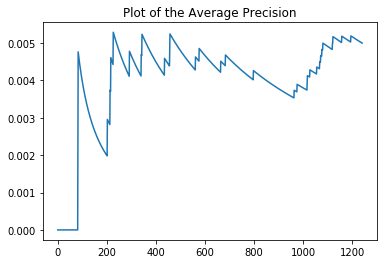

In [12]:
plt.figure()
X = [x for x in range(len(precisions))]
plt.plot(X,precisions)
plt.title('Plot of the Average Precision')
plt.show()

The first good prediction is around 100. Then, the average precision stays more or less stable. The ranking doesn't work really well here.

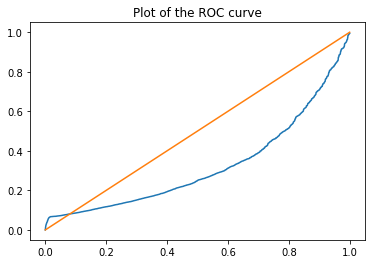

In [13]:
plt.figure()
plt.plot(fp_rates, recalls, fp_rates,fp_rates )
plt.title('Plot of the ROC curve')
plt.show()

In [14]:
AUROC(fp_rates, recalls)

0.3232597121838028

In [15]:
MAP

0.006829746314170262

### Second dataset: INFECTIOUS

The second dataset we work on is a network representing the face-to-face behaviour of
people during the exhibition INFECTIOUS: STAY AWAY in 2009 at the Science Gallery
in Dublin. It is undirected, unweighted but has multiple edges. It is composed of 410
vertices (visitors) and 17,298 edges (human face-to-face).

In [16]:
# Importation of the dataset: INFECTIOUS
# http://konect.uni-koblenz.de/networks/sociopatterns-infectious 

INF = []
with open('sociopatterns-infectious\out.sociopatterns-infectious') as inputfile:
    for line in inputfile:
        INF.append(line.strip().split(','))
INF = INF[2:] # list of all the edges
random.shuffle(INF) # we randomly shuffle the edges

# test size
num_edges_INF = len(INF)
num_vertices_INF = 410
test_size_INF = int(num_edges_INF/5)

# Contains the 5 parts forming the whole dataset
parts_INF = []

start = 0
end = test_size_INF
for part in range(5):  # We create the 5 parts
    if end>num_edges_INF:
        parts_INF.append(INF[start:])
    else:parts_INF.append(INF[start:end])
    start = end
    end = start + test_size_INF



In [17]:
INF_G = nx.MultiGraph()
for edge in range(len(INF)):
    nodes = INF[edge][0].split(' ')
    INF_G.add_edge(int(nodes[0]), int(nodes[1])) 
INF_nodes = INF_G.nodes()

In [18]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

INF_graphs = []
INF_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.MultiGraph()
    G.add_nodes_from(INF_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_INF[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                # We don't want duplicates because we can only predict an edge once
                # We cannot predict the number of edges to add
                if [min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))] not in target_links:
                    target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
                
    INF_graphs.append(G)
    INF_targets.append(target_links)

In [19]:
precisions_INF, MAP_INF, recalls_INF, fp_rates_INF = CV_results(INF_graphs,INF_targets, multi=True)

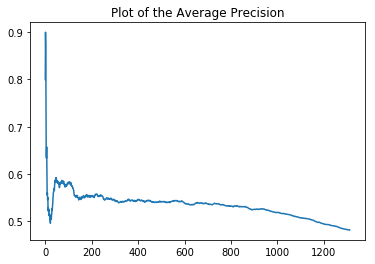

In [20]:
plt.figure()
X_INF = [x for x in range(len(precisions_INF))]
plt.plot(X_INF,precisions_INF)
plt.title('Plot of the Average Precision')
plt.show()

We observe an extreme good score at the beginning, which falls suddenly and then slowly decreases. The ranking is quite good here.

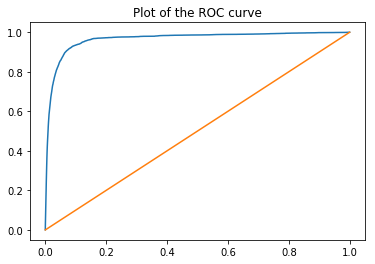

In [21]:
plt.figure()
plt.plot(fp_rates_INF, recalls_INF, fp_rates_INF,fp_rates_INF )
plt.title('Plot of the ROC curve')
plt.show()

In [22]:
AUROC(fp_rates_INF, recalls_INF)

0.9651784899519162

In [23]:
MAP_INF

0.5387404516356183

### Third dataset: ADOLESCENT

The third dataset is also social related. It has been created from a survey that took place
in 1994/1995. Each student was asked to list his 5 best female and his 5 male friends. The
network is composed of 2,539 vertices (students), and 12,969 edges (friendships). It is
directed and weighted. The bigger the weight of an edge is the more important the
relation is.

In [24]:
# Importation of the dataset: ADOLESCENT
# http://konect.uni-koblenz.de/networks/moreno_health

ADO = []
with open('moreno_health\out.moreno_health_health') as inputfile:
    for line in inputfile:
        ADO.append(line.strip().split(','))
ADO = ADO[2:] # list of all the edges
random.shuffle(ADO) # we randomly shuffle the edges

# test size
num_edges_ADO = len(ADO)
num_vertices_ADO = 2539
test_size_ADO = int(num_edges_ADO/5)

# Contains the 5 parts forming the whole dataset
parts_ADO = []

start = 0
end = test_size_ADO
for part in range(5):  # We create the 5 parts
    if end>num_edges_ADO:
        parts_ADO.append(ADO[start:])
    else:parts_ADO.append(ADO[start:end])
    start = end
    end = start + test_size_ADO


In [25]:
ADO_G = nx.DiGraph()
for edge in range(len(ADO)):
    nodes = ADO[edge][0].split(' ')
    ADO_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
ADO_nodes = ADO_G.nodes()

In [26]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

ADO_graphs = []
ADO_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.DiGraph()
    G.add_nodes_from(ADO_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_ADO[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                target_links.append([int(nodes[0]),int(nodes[1])])
                
                

    ADO_graphs.append(G)
    ADO_targets.append(target_links)
  

In [27]:
precisions_ADO,MAP_ADO,recalls_ADO,fp_rates_ADO = CV_results(ADO_graphs,ADO_targets,'directed')

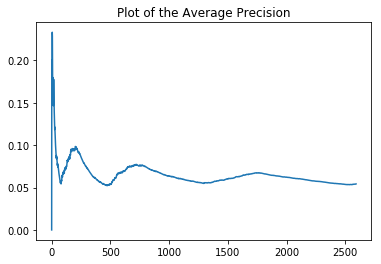

In [28]:
plt.figure()
X_ADO = [x for x in range(len(precisions_ADO))]
plt.plot(X_ADO,precisions_ADO)
plt.title('Plot of the Average Precision')
plt.show()

The figure shows a high peak for the first prediction and a stabilisation at a lower score. The performance of the ranking on the dataset is quite good considering the predictions themselves are not so good.

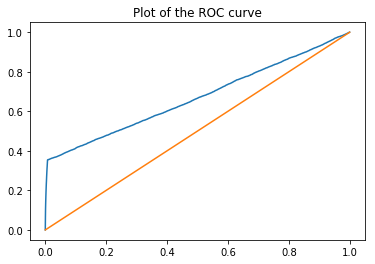

In [29]:
plt.figure()
plt.plot(fp_rates_ADO, recalls_ADO, fp_rates_ADO,fp_rates_ADO )
plt.title('Plot of the ROC curve')
plt.show()

In [30]:
AUROC(fp_rates_ADO, recalls_ADO)

0.6694692217456362

In [31]:
MAP_ADO

0.07217356573342983

### Fourth dataset: MISERABLES

The last dataset is entirely different since it is pure fiction. It contains co-occurrences of
characters in Victor Hugo's novel Les Misérables. The network is undirected and positive
weighted. It is composed of 77 vertices (the characters), 254 edges (co-occurrences in a
chapter).

In [32]:
# Importation of the dataset: MISERABLES
# http://konect.uni-koblenz.de/networks/moreno_lesmis

MIS = []
with open('moreno_lesmis\out.moreno_lesmis_lesmis') as inputfile:
    for line in inputfile:
        MIS.append(line.strip().split(','))
MIS = MIS[2:] # list of all the edges
random.shuffle(MIS) # we randomly shuffle the edges

# test size
num_edges_MIS = len(MIS)
num_vertices_MIS = 77
test_size_MIS = int(num_edges_MIS/5)

# Contains the 5 parts forming the whole dataset
parts_MIS = []

start = 0
end = test_size_MIS
for part in range(5):  # We create the 5 parts
    if end>num_edges_MIS:
        parts_MIS.append(MIS[start:])
    else:parts_MIS.append(MIS[start:end])
    start = end
    end = start + test_size_MIS



In [33]:
MIS_G = nx.Graph()
for edge in range(len(MIS)):
    nodes = MIS[edge][0].split(' ')
    MIS_G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2]))
MIS_nodes = MIS_G.nodes()

In [34]:
# graphs contains the 5 different training networks 
# targets contains the target links corresponding

MIS_graphs = []
MIS_targets = []

for i in range(5):     # i is the index of the folder we won't use
    G = nx.Graph()
    G.add_nodes_from(MIS_nodes)
    target_links = [] 
    for j in range(5): # We use every other folder
        data = parts_MIS[j]
        if j!=i:        
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                G.add_edge(int(nodes[0]), int(nodes[1]), weight=float(nodes[2])) 
                
                
        else:
            for edge in range(len(data)):
                nodes = data[edge][0].split(' ')
                # For undirected network, we write the min node first
                target_links.append([min(int(nodes[0]),int(nodes[1])),max(int(nodes[0]),int(nodes[1]))])
                
                

    MIS_graphs.append(G)
    MIS_targets.append(target_links)

In [35]:
precisions_MIS, MAP_MIS, recalls_MIS, fp_rates_MIS = CV_results(MIS_graphs,MIS_targets)

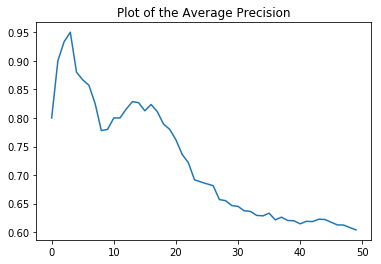

In [36]:
plt.figure()
X_MIS = [x for x in range(len(precisions_MIS))]
plt.plot(X_MIS,precisions_MIS)
plt.title('Plot of the Average Precision')
plt.show()

Eventhough the first prediction is not good, the following ones are correct and after that, the function decreases slowly, proof of the ranking efficiency.

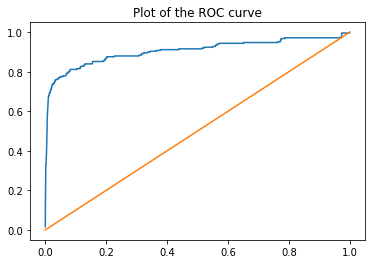

In [37]:
plt.figure()
plt.plot(fp_rates_MIS, recalls_MIS, fp_rates_MIS,fp_rates_MIS )
plt.title('Plot of the ROC curve')
plt.show()

In [38]:
AUROC(fp_rates_MIS, recalls_MIS)

0.9054107623318502

In [39]:
MAP_MIS

0.758581049958542